In [ ]:
%%capture
%pip install openmeteo-requests requests-cache retry-requests numpy pandas matplotlib torch scikit-learn scipy seaborn statsmodels seaborn

In [82]:
import openmeteo_requests
import requests_cache
import torch 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from retry_requests import retry
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
# from statsmodels.tsa.stattools import coint_johansen # ????

In [48]:
# Load solar data
solar_ts = pd.read_csv("/home/moonchild/PythonProjects/solar-prediction/data/energy_charts.csv", sep=",", header=0)
solar_ts["date"] = pd.to_datetime(solar_ts["Datum"], utc=True)
solar_ts.drop(columns=["Datum"], inplace=True)
solar_ts.set_index("date", inplace=True)

# Remove Duplicates

In [49]:
if solar_ts.index.duplicated().any():
    print("Duplicates found:")
    print(solar_ts[solar_ts.index.duplicated(keep=False)])

# Keep the first occurrence of each duplicate
solar_ts = solar_ts[~solar_ts.index.duplicated(keep='first')]
pd.Series(solar_ts.index.duplicated()).value_counts()

Duplicates found:
                           Leistung
date                               
2015-03-01 00:00:00+00:00       0.0
2015-03-01 00:15:00+00:00       0.0
2015-03-01 00:30:00+00:00       0.0
2015-03-01 00:45:00+00:00       0.0
2015-03-01 00:00:00+00:00       0.0
...                             ...
2023-09-29 00:45:00+00:00       0.0
2023-09-29 00:00:00+00:00       0.0
2023-09-29 00:15:00+00:00       0.0
2023-09-29 00:30:00+00:00       0.0
2023-09-29 00:45:00+00:00       0.0

[144 rows x 1 columns]


False    327522
Name: count, dtype: int64

# Interpolate Missing timestamps

In [50]:
# Check for continuity
expected_range = pd.date_range(start=solar_ts.index.min(), end=solar_ts.index.max(), freq='15min')
missing_times = expected_range.difference(solar_ts.index)
if not missing_times.empty:
    print(f"Missing timestamps detected: {missing_times}")
    

# Create a full range of 15-min intervals
full_range = pd.date_range(start=solar_ts.index.min(), end=solar_ts.index.max(), freq='15min')
solar_ts = solar_ts.reindex(full_range)

# Interpolate missing values using time interpolation
solar_ts.interpolate(method='time', inplace=True)

Missing timestamps detected: DatetimeIndex(['2015-02-28 23:00:00+00:00', '2015-02-28 23:15:00+00:00',
               '2015-02-28 23:30:00+00:00', '2015-02-28 23:45:00+00:00',
               '2015-09-25 02:00:00+00:00', '2015-09-25 02:15:00+00:00',
               '2015-09-25 02:30:00+00:00', '2015-09-25 02:45:00+00:00',
               '2016-02-27 02:00:00+00:00', '2016-02-27 02:15:00+00:00',
               '2016-02-27 02:30:00+00:00', '2016-02-27 02:45:00+00:00',
               '2016-09-30 02:00:00+00:00', '2016-09-30 02:15:00+00:00',
               '2016-09-30 02:30:00+00:00', '2016-09-30 02:45:00+00:00',
               '2017-02-26 02:00:00+00:00', '2017-02-26 02:15:00+00:00',
               '2017-02-26 02:30:00+00:00', '2017-02-26 02:45:00+00:00',
               '2017-09-29 02:00:00+00:00', '2017-09-29 02:15:00+00:00',
               '2017-09-29 02:30:00+00:00', '2017-09-29 02:45:00+00:00',
               '2018-02-25 02:00:00+00:00', '2018-02-25 02:15:00+00:00',
               '2018-0

In [51]:
# Check for continuity
expected_range = pd.date_range(start=solar_ts.index.min(), end=solar_ts.index.max(), freq='15min')
missing_times = expected_range.difference(solar_ts.index)
if not missing_times.empty:
    print(f"Missing timestamps detected: {missing_times}")

# Resample from 15min to hourly sequences

In [52]:
# Resample
solar_ts = solar_ts.resample('h').sum()

# Set the frequency to the inferred frequency of the DataFrame index
solar_ts = solar_ts.asfreq(pd.infer_freq(solar_ts.index))
solar_ts

,Leistung
2014-12-31 23:00:00+00:00,0.0
2015-01-01 00:00:00+00:00,0.0
2015-01-01 01:00:00+00:00,0.0
2015-01-01 02:00:00+00:00,0.0
2015-01-01 03:00:00+00:00,0.0
...,...
2024-05-05 05:00:00+00:00,19682.8
2024-05-05 06:00:00+00:00,37439.6
2024-05-05 07:00:00+00:00,58640.1
2024-05-05 08:00:00+00:00,79882.7


In [55]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required train variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 52.5244,
	"longitude": 13.4105,
	"start_date": "2014-01-01",
	"end_date": "2024-05-01",
	"hourly": [
        "temperature_2m", 
        "cloud_cover", 
        "shortwave_radiation", 
        "diffuse_radiation", 
        "direct_normal_irradiance", 
        "is_day", 
        "sunshine_duration"
        ],
	"timezone": "Europe/Berlin"
}

responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_cloud_cover = hourly.Variables(1).ValuesAsNumpy()
hourly_shortwave_radiation = hourly.Variables(2).ValuesAsNumpy()
hourly_diffuse_radiation = hourly.Variables(3).ValuesAsNumpy()
hourly_direct_normal_irradiance = hourly.Variables(4).ValuesAsNumpy()
hourly_is_day = hourly.Variables(5).ValuesAsNumpy()
hourly_sunshine_duration = hourly.Variables(6).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["cloud_cover"] = hourly_cloud_cover
hourly_data["shortwave_radiation"] = hourly_shortwave_radiation
hourly_data["diffuse_radiation"] = hourly_diffuse_radiation
hourly_data["direct_normal_irradiance"] = hourly_direct_normal_irradiance
hourly_data["is_day"] = hourly_is_day
hourly_data["sunshine_duration"] = hourly_sunshine_duration

hourly_dataframe = pd.DataFrame(data = hourly_data)
hourly_dataframe.set_index("date", inplace = True)

Coordinates 52.5483283996582°N 13.407821655273438°E
Elevation 46.0 m asl
Timezone b'Europe/Berlin' b'CEST'
Timezone difference to GMT+0 7200 s


In [ ]:
# hourly_dataframe.info()
# hourly_dataframe.describe()
# hourly_dataframe.plot(x = "date", y = "temperature_2m")
# hourly_dataframe.tail()

In [57]:
# merge with solar_ts
energy_ts = solar_ts.merge(hourly_dataframe, left_index=True, right_index=True, how='inner')
energy_ts.drop(columns=['is_day', 'sunshine_duration'], inplace=True)
energy_ts.info()
energy_ts

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 81815 entries, 2014-12-31 23:00:00+00:00 to 2024-05-01 21:00:00+00:00
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Leistung                  81815 non-null  float64
 1   temperature_2m            81815 non-null  float32
 2   cloud_cover               81815 non-null  float32
 3   shortwave_radiation       81815 non-null  float32
 4   diffuse_radiation         81815 non-null  float32
 5   direct_normal_irradiance  81815 non-null  float32
dtypes: float32(5), float64(1)
memory usage: 2.8 MB


,Leistung,temperature_2m,cloud_cover,shortwave_radiation,diffuse_radiation,direct_normal_irradiance
2014-12-31 23:00:00+00:00,0.0,3.937000,100.000000,0.0,0.0,0.000000
2015-01-01 00:00:00+00:00,0.0,3.737000,83.699997,0.0,0.0,0.000000
2015-01-01 01:00:00+00:00,0.0,3.587000,61.500000,0.0,0.0,0.000000
2015-01-01 02:00:00+00:00,0.0,3.287000,100.000000,0.0,0.0,0.000000
2015-01-01 03:00:00+00:00,0.0,2.937000,80.099998,0.0,0.0,0.000000
...,...,...,...,...,...,...
2024-05-01 17:00:00+00:00,14386.7,22.556499,24.900002,195.0,81.0,385.906311
2024-05-01 18:00:00+00:00,1648.6,21.206501,26.100000,86.0,41.0,308.933136
2024-05-01 19:00:00+00:00,1.5,19.706501,30.900002,6.0,5.0,14.269454
2024-05-01 20:00:00+00:00,0.0,18.606501,23.400002,0.0,0.0,0.000000


In [59]:
# Split
train_ts = energy_ts[:'2022-12-31']  # Training data up to the end of 2022
val_ts = energy_ts['2023-01-01':'2023-12-31']  # Validation data for the year 2023
test_ts = energy_ts['2024-01-01':]  # Test data from the beginning of 2024 onwards

# Normalise

In [80]:
# noramlise train val and test data based on train data
train_mean = train_ts.mean()
train_std = train_ts.std()

train_ts = (train_ts - train_mean) / train_std
val_ts = (val_ts - train_mean) / train_std
test_ts = (test_ts - train_mean) / train_std

**Statioarity**

In [ ]:
# switch train and val temporarily for testing to save memory
# train_ts = val_ts
# train_ts

In [81]:
# Stationarity - Augmented Dicky Fuller Test
def make_stationary(train_ts, val_ts, test_ts):
    """
    Perform the Augmented Dickey-Fuller test on train_ts. If train_ts is not stationary,
    difference train_ts, val_ts, and test_ts based on the train_ts result.
    
    Parameters:
    train_ts (pd.DataFrame): The training time series data.
    val_ts (pd.DataFrame): The validation time series data.
    test_ts (pd.DataFrame): The test time series data.
    
    Returns:
    None
    """
    def perform_adf(series, column_name):
        result = adfuller(series, autolag='AIC')
        print(f'ADF Statistic for {column_name}: {result[0]}')
        print(f'p-value for {column_name}: {result[1]}')
        for key, value in result[4].items():
            print(f'Critical Values for {column_name} {key}: {value}')
        return result[1] < 0.05  # Return True if the series is stationary

    def check_and_difference(series, column_name):
        differenced = False
        is_stationary = perform_adf(series, column_name)
        iteration = 0
        while not is_stationary:
            print(f'The time series {column_name} is not stationary. Differencing the series and re-testing...')
            series = series.diff().dropna()
            is_stationary = perform_adf(series, f'{column_name} (Differenced {iteration+1})')
            differenced = True
            iteration += 1
        
        if is_stationary:
            print(f'The time series {column_name} is stationary after differencing {iteration} time(s).')
        else:
            print(f'The time series {column_name} is still not stationary after differencing {iteration} time(s).')
        
        return series, differenced

    for col in train_ts.columns:
        print(f'Checking stationarity for {col}')
        train_ts[col], differenced = check_and_difference(train_ts[col], col)
        if differenced:
            val_ts[col] = val_ts[col].diff().dropna()
            test_ts[col] = test_ts[col].diff().dropna()
        print("\n")  # Add a space between outputs

# Iterate over each column and perform the combined ADF test
make_stationary(train_ts, val_ts, test_ts)

Checking stationarity for Leistung
ADF Statistic for Leistung: -9.645135860949505
p-value for Leistung: 1.4847800325203758e-16
Critical Values for Leistung 1%: -3.4304433339935243
Critical Values for Leistung 5%: -2.861581251968671
Critical Values for Leistung 10%: -2.5667919570132556
The time series Leistung is stationary after differencing 0 time(s).


Checking stationarity for temperature_2m
ADF Statistic for temperature_2m: -7.4054659070576285
p-value for temperature_2m: 7.364793314070563e-11
Critical Values for temperature_2m 1%: -3.4304433339935243
Critical Values for temperature_2m 5%: -2.861581251968671
Critical Values for temperature_2m 10%: -2.5667919570132556
The time series temperature_2m is stationary after differencing 0 time(s).


Checking stationarity for cloud_cover
ADF Statistic for cloud_cover: -22.273205437431745
p-value for cloud_cover: 0.0
Critical Values for cloud_cover 1%: -3.430443328665286
Critical Values for cloud_cover 5%: -2.8615812496137214
Critical Values

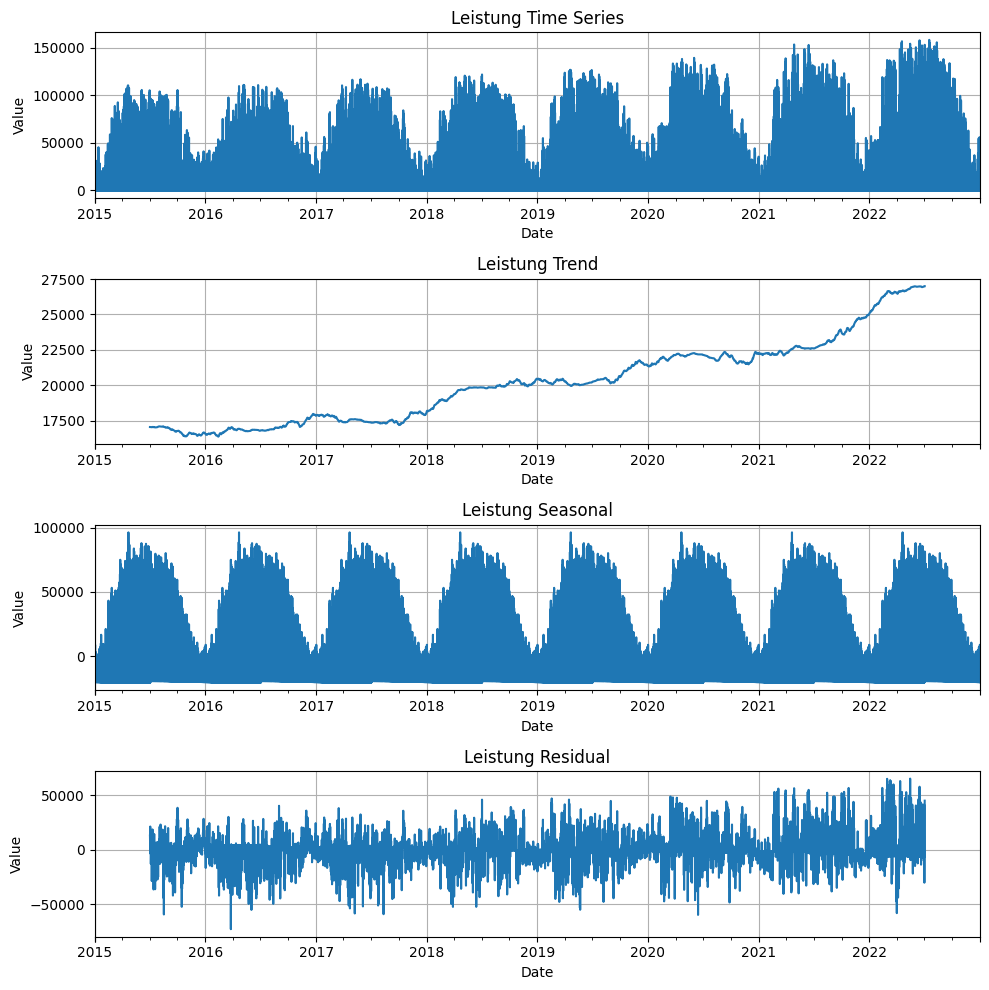

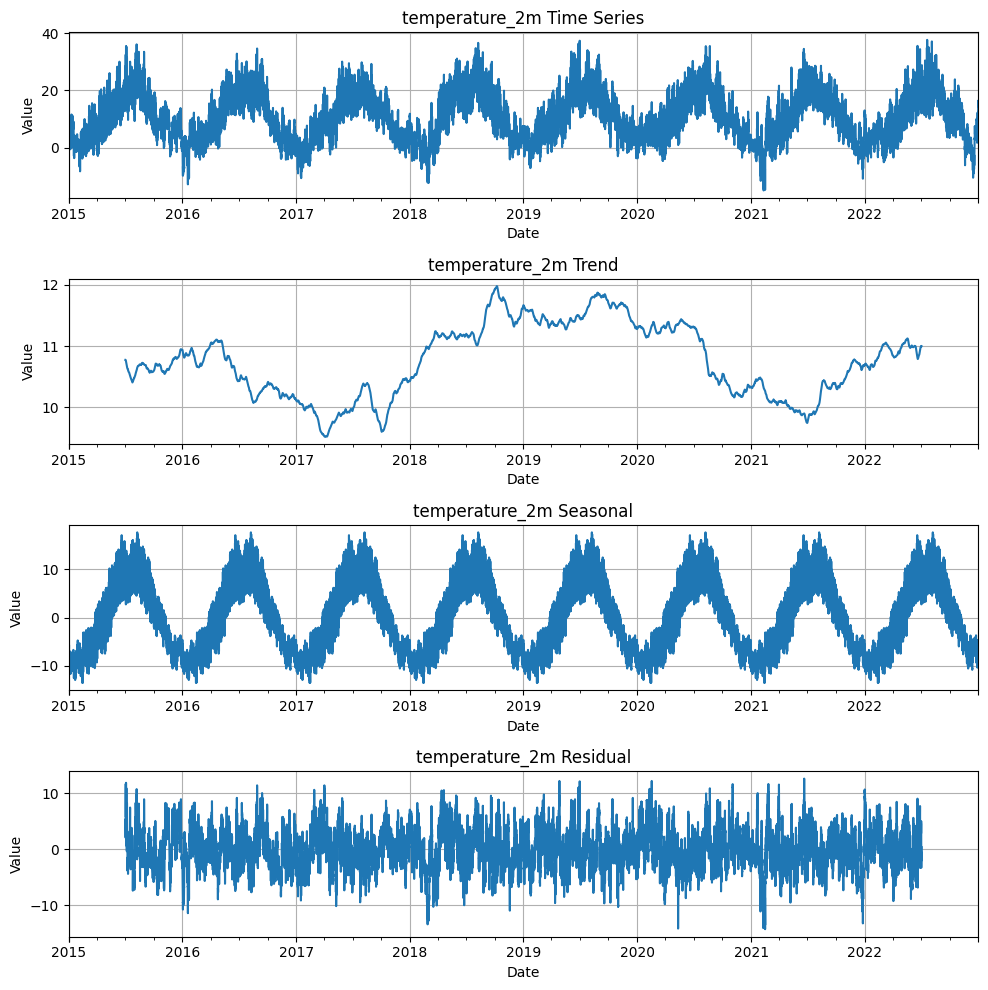

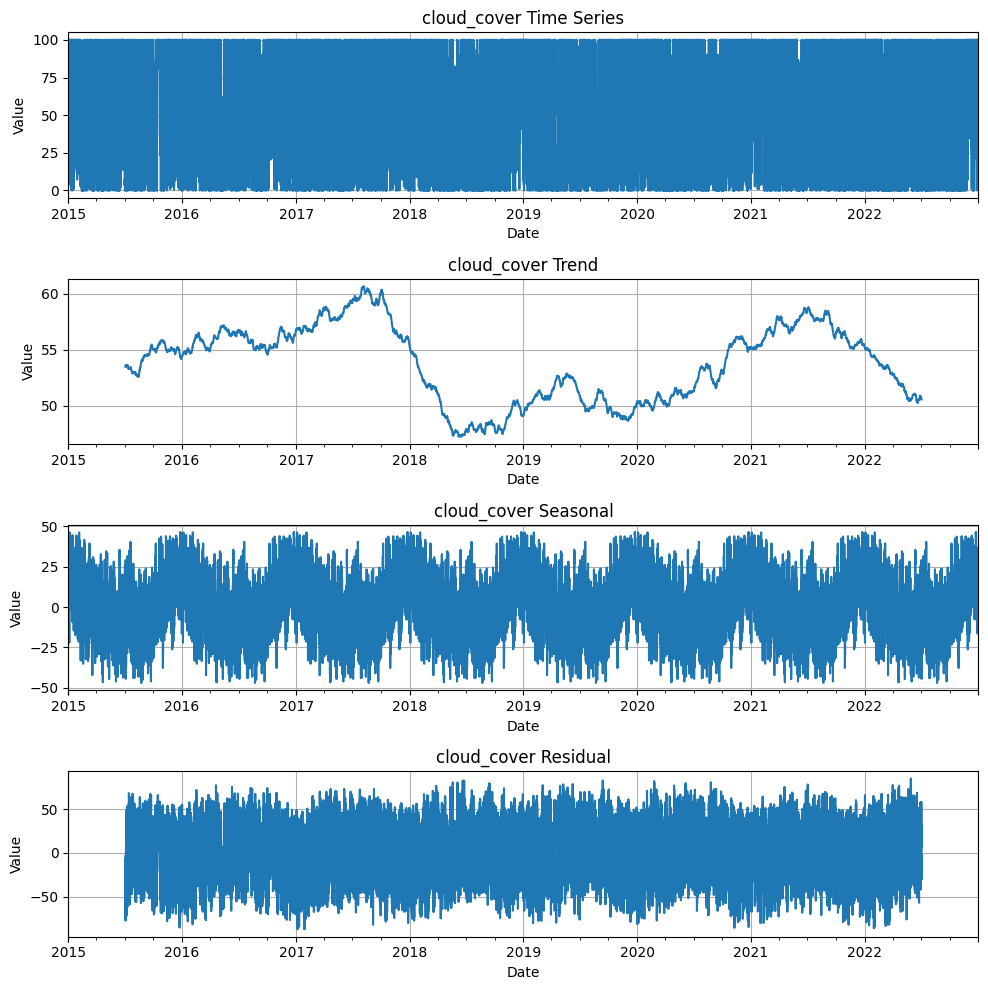

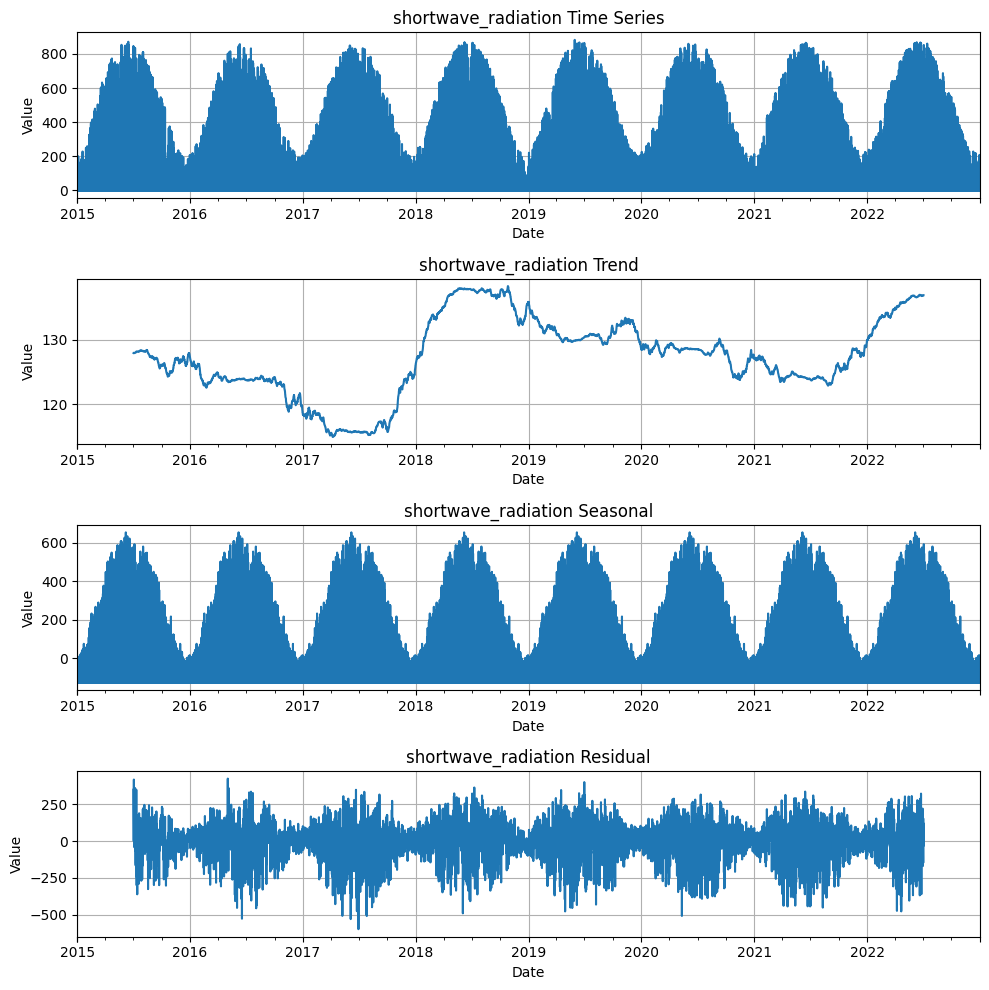

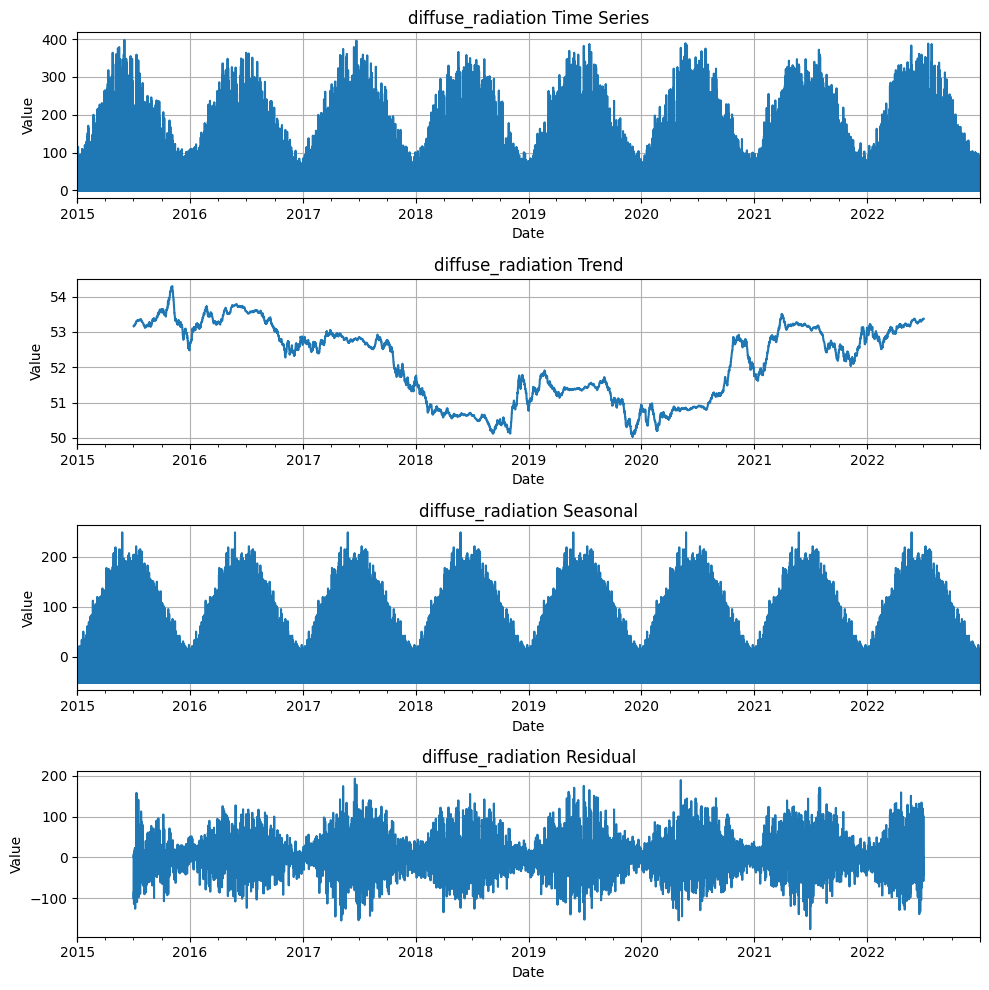

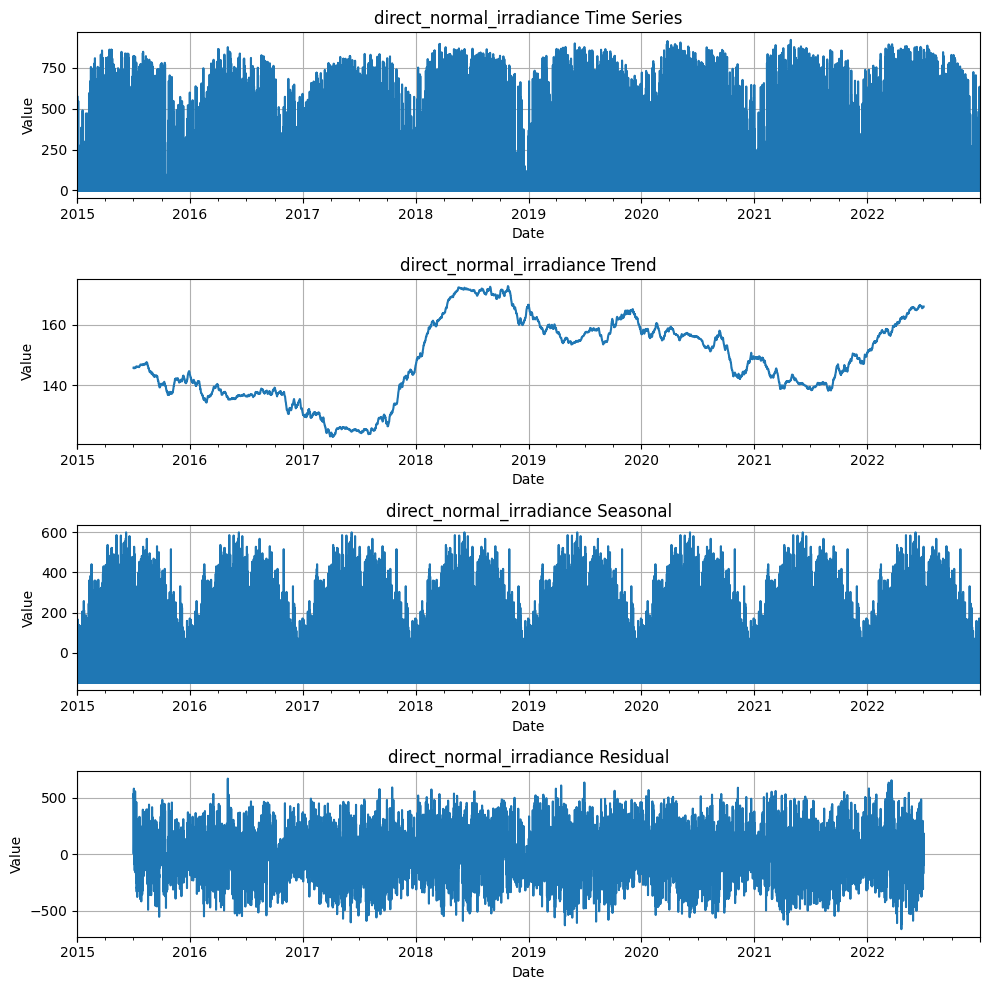

In [64]:
# Plot and decompose each time series as grid of plots
for column in train_ts.columns:
    fig, axes = plt.subplots(4, 1, figsize=(10, 10))
    axes[0].set_title(f"{column} Time Series")
    train_ts[column].plot(ax=axes[0])
    axes[0].set_ylabel("Value")
    axes[0].set_xlabel("Date")
    axes[0].grid(True)
    
    decomposition = seasonal_decompose(train_ts[column], model='additive', period=8760)
    decomposition.trend.plot(ax=axes[1])
    axes[1].set_title(f"{column} Trend")
    axes[1].set_ylabel("Value")
    axes[1].set_xlabel("Date")
    axes[1].grid(True)
    
    decomposition.seasonal.plot(ax=axes[2])
    axes[2].set_title(f"{column} Seasonal")
    axes[2].set_ylabel("Value")
    axes[2].set_xlabel("Date")
    axes[2].grid(True)
    
    decomposition.resid.plot(ax=axes[3])
    axes[3].set_title(f"{column} Residual")
    axes[3].set_ylabel("Value")
    axes[3].set_xlabel("Date")
    axes[3].grid(True)
    
    plt.tight_layout()
    plt.show()

*Test ACF and PACF*

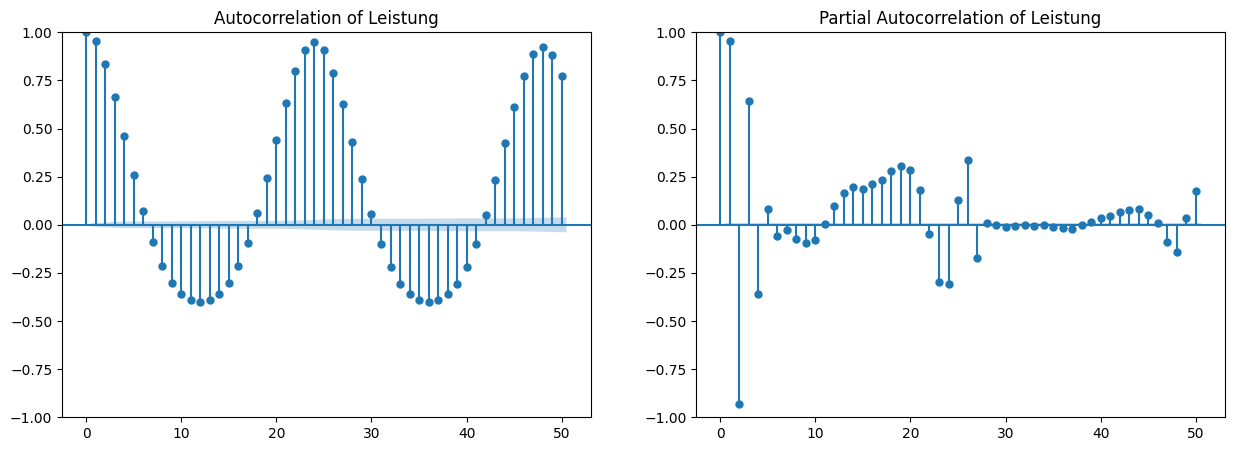

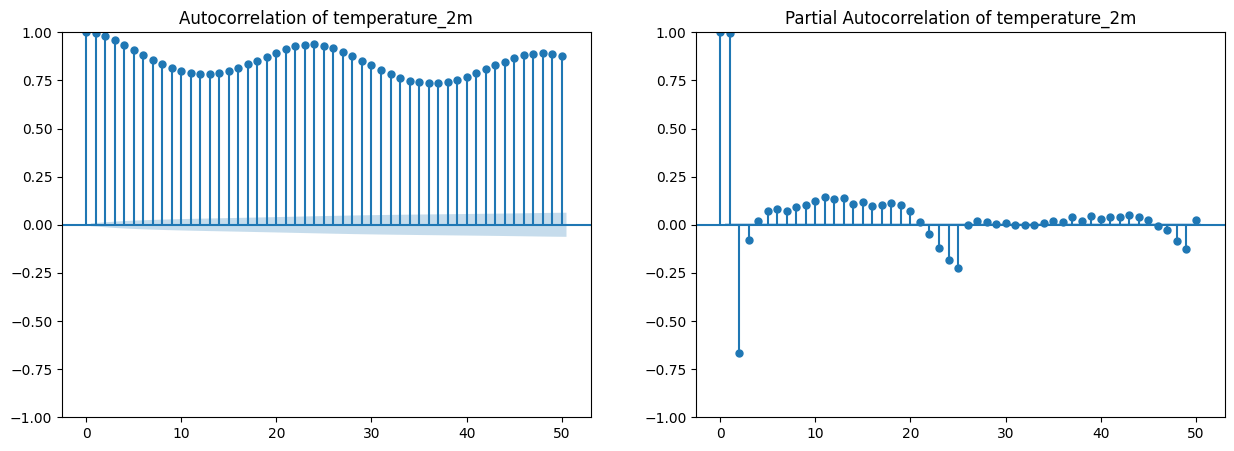

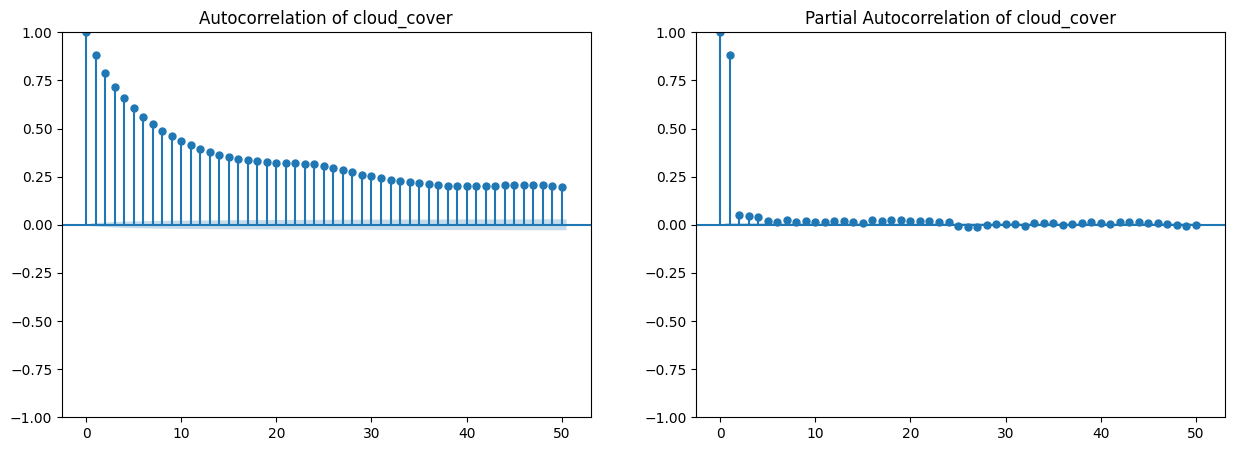

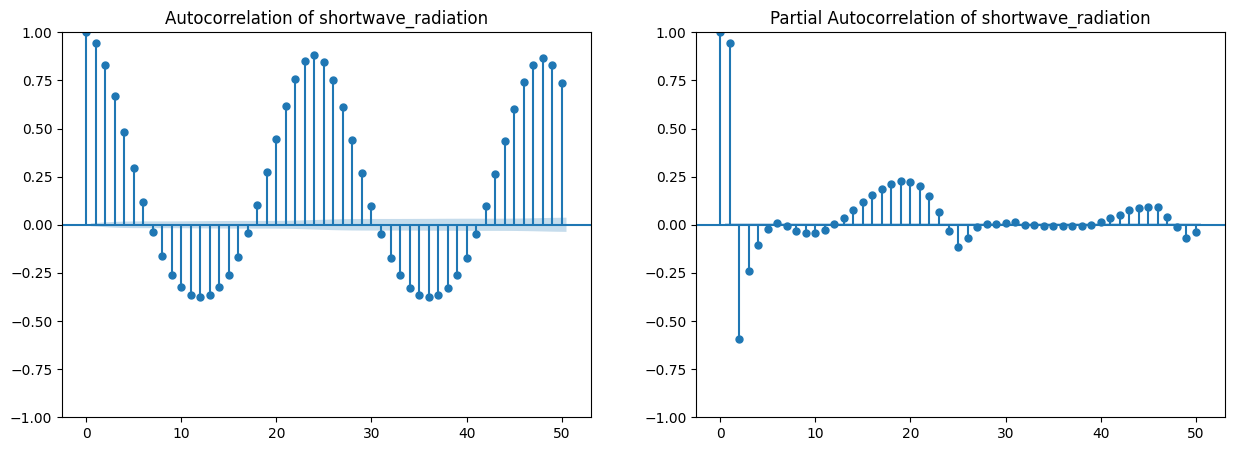

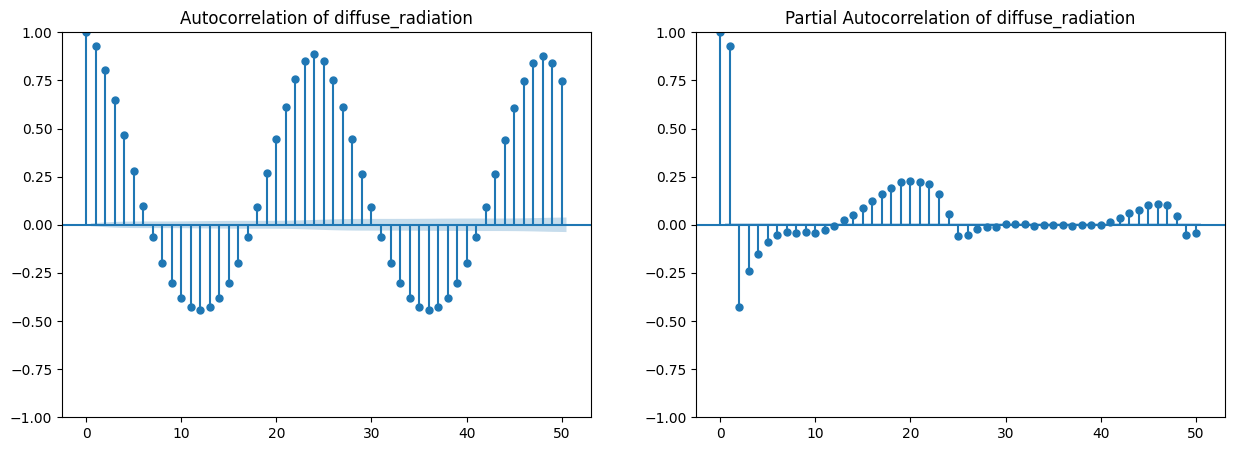

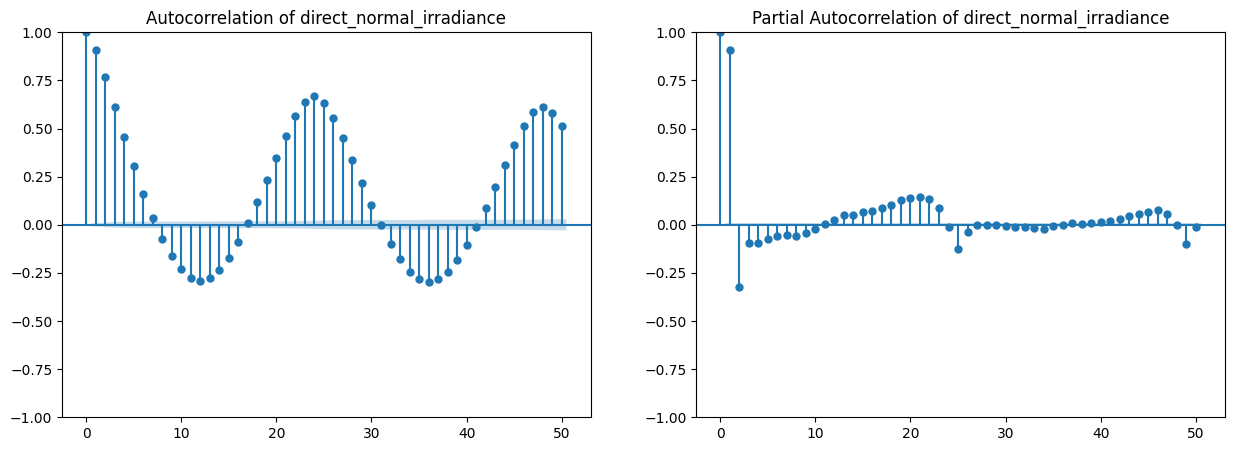

In [62]:
# Check autocorrelation of each series in the training data and display as grid

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
for col in train_ts.columns:
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    plot_acf(train_ts[col], ax=ax[0], lags=50, title=f'Autocorrelation of {col}')
    plot_pacf(train_ts[col], ax=ax[1], lags=50, title=f'Partial Autocorrelation of {col}')
    plt.show()

# MULTIVARIATE ANALYSIS

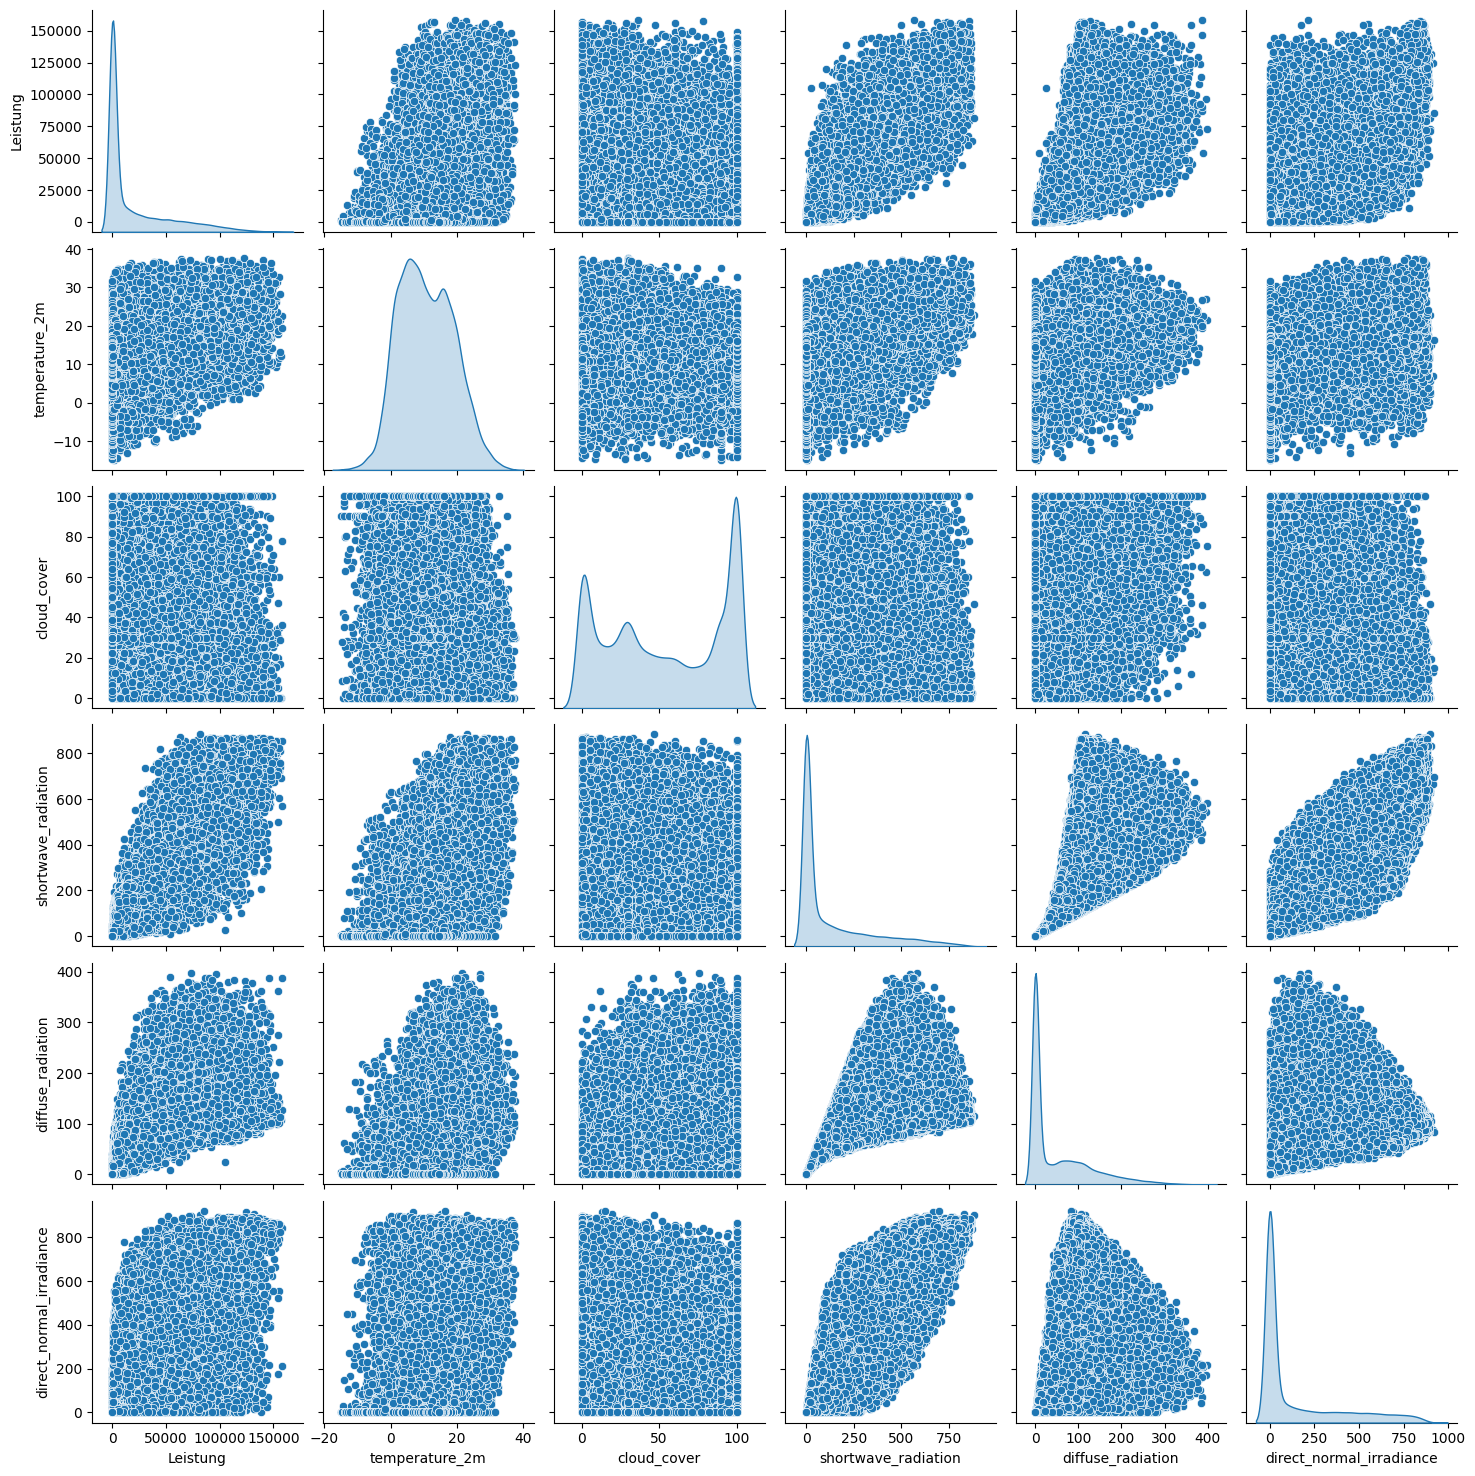

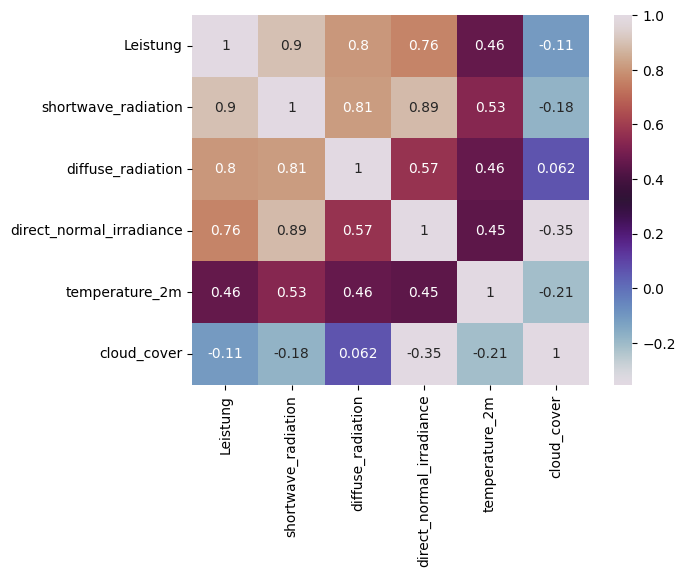

                          Leistung  shortwave_radiation  diffuse_radiation  direct_normal_irradiance  temperature_2m  cloud_cover
Leistung                  1.000000             0.899092           0.804902                  0.763227        0.460936    -0.107119
shortwave_radiation       0.899092             1.000000           0.814952                  0.885131        0.532164    -0.179667
diffuse_radiation         0.804902             0.814952           1.000000                  0.570988        0.462649     0.061885
direct_normal_irradiance  0.763227             0.885131           0.570988                  1.000000        0.445571    -0.353543
temperature_2m            0.460936             0.532164           0.462649                  0.445571        1.000000    -0.212173
cloud_cover              -0.107119            -0.179667           0.061885                 -0.353543       -0.212173     1.000000


In [65]:
# Scatter Plots (pairwise)
sns.pairplot(train_ts, diag_kind="kde")  
plt.show() 

# Sort features based on target variable correlation (absolute value)
sorted_features = train_ts.corr().iloc[0,:].abs().sort_values(ascending=False).index.tolist()

# Ordered heatmap 
corr_matrix = train_ts[sorted_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap="twilight")  
plt.show()

# Correlation Matrix
print(corr_matrix.to_string())  # Print the correlation matrix as text

In [66]:
# Granger Causality Tests for the series in train_ts
from statsmodels.tsa.stattools import grangercausalitytests

for col in train_ts.columns:
    for col2 in train_ts.columns:
        if col != col2:
            print(f'Granger Causality Test for {col} and {col2}')
            data = pd.concat([train_ts[col], train_ts[col2]], axis=1)
            max_lag = 12
            results = grangercausalitytests(data, max_lag, verbose=True)
            print("\n")  # Add a space between outputs

Granger Causality Test for Leistung and temperature_2m

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1617.3700, p=0.0000  , df_denom=70125, df_num=1
ssr based chi2 test:   chi2=1617.4392, p=0.0000  , df=1
likelihood ratio test: chi2=1599.0687, p=0.0000  , df=1
parameter F test:         F=1617.3700, p=0.0000  , df_denom=70125, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1671.8376, p=0.0000  , df_denom=70122, df_num=2
ssr based chi2 test:   chi2=3343.9136, p=0.0000  , df=2


/home/moonchild/PythonProjects/solar-prediction/solar_venv/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


likelihood ratio test: chi2=3266.6356, p=0.0000  , df=2
parameter F test:         F=1671.8376, p=0.0000  , df_denom=70122, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=697.4827, p=0.0000  , df_denom=70119, df_num=3
ssr based chi2 test:   chi2=2092.6571, p=0.0000  , df=3
likelihood ratio test: chi2=2062.0408, p=0.0000  , df=3
parameter F test:         F=697.4827, p=0.0000  , df_denom=70119, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=469.9966, p=0.0000  , df_denom=70116, df_num=4
ssr based chi2 test:   chi2=1880.2278, p=0.0000  , df=4
likelihood ratio test: chi2=1855.4627, p=0.0000  , df=4
parameter F test:         F=469.9966, p=0.0000  , df_denom=70116, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=348.6451, p=0.0000  , df_denom=70113, df_num=5
ssr based chi2 test:   chi2=1743.4991, p=0.0000  , df=5
likelihood ratio test: chi2=1722.1774, p=0.0000  , df=5
parameter F test:  

# Baseline tbd

# VAR

In [85]:
for i in [1,12,24,48,96,168,336,720,1440]:
    model = VAR(train_ts)
    results = model.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()

/home/moonchild/PythonProjects/solar-prediction/solar_venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/moonchild/PythonProjects/solar-prediction/solar_venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Order = 1
AIC:  -18.299190788404648
BIC:  -18.293705971330848

Order = 12
AIC:  -21.713349233229653
BIC:  -21.656142433127076



/home/moonchild/PythonProjects/solar-prediction/solar_venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Order = 24
AIC:  -22.742662535896176
BIC:  -22.629015264296076



/home/moonchild/PythonProjects/solar-prediction/solar_venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Order = 48
AIC:  -23.125873035850532
BIC:  -22.899293167852324



/home/moonchild/PythonProjects/solar-prediction/solar_venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Order = 96
AIC:  -23.307863503308084
BIC:  -22.855211596279393



/home/moonchild/PythonProjects/solar-prediction/solar_venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Order = 168
AIC:  -23.37032550119086
BIC:  -22.578047420953112



/home/moonchild/PythonProjects/solar-prediction/solar_venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Order = 336
AIC:  -23.34079270865575
BIC:  -21.75362632457748



/home/moonchild/PythonProjects/solar-prediction/solar_venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


: 